In [1]:
import os
os.chdir("/kaggle/input/omniglot/")

In [2]:
import numpy as np
import cv2
import tqdm
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision

In [3]:
class DataLoader():
    def read_characters(self, dataset_directory, script_directory):
        image_data = []
        image_tag = []
        characters = os.listdir(os.path.join(dataset_directory, script_directory))
        
        for char in characters:
            images = os.listdir(os.path.join(dataset_directory,script_directory,char))

            for img in images:
                try:
                    img_path = os.path.join(dataset_directory,script_directory,char,img)
                    img_array = cv2.resize(cv2.imread(img_path),(28,28))
                    
                    img_rotated_90 = cv2.rotate(img_array, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img_array, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img_array, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    # print(img_path)
                    
                    image_data.extend((img_array, img_rotated_90, img_rotated_180, img_rotated_270))
                    image_tag.extend((
                        script_directory+"_"+char+"_"+"0",
                        script_directory+"_"+char+"_"+"90",
                        script_directory+"_"+char+"_"+"180",
                        script_directory+"_"+char+"_"+"270"
                    ))
                except AssertionError as error:
                    print(error)
        return np.array(image_data), np.array(image_tag)

    def read_images(self, dataset_directory):
        pool = mp.Pool(mp.cpu_count())
        scripts_list = os.listdir(dataset_directory)
        
        results = [pool.apply(self.read_characters, args=(dataset_directory, scripts)) for scripts in scripts_list]
        pool.close()

        img_array = None
        img_tag = None

        for result in results:
            if img_array is None:
                img_array = result[0]
                img_tag = result[1]
            else:
                img_array = np.vstack([img_array, result[0]])
                img_tag = np.concatenate([img_tag, result[1]])
        return img_array, img_tag

    def extract_sample(self, n_way, n_shot, n_query, img_array, img_tag):
        sample = []
        K = np.random.choice(np.unique(img_tag), n_way, replace=False)
        
        for cls in K:
            img_cls = img_array[img_tag == cls] # Choosing img with particular class
            perm = np.random.permutation(img_cls) # Permuting them
            sample_cls = perm[:(n_shot+n_query)] # Picking Support and Query images
            sample.append(sample_cls)
        
        sample = np.array(sample)
        sample = torch.from_numpy(sample).float()
        sample = sample.permute(0,1,4,2,3) # reordering the images
        return({
            'images': sample,
            'n_way': n_way,
            'n_shot': n_shot,
            'n_query': n_query
            })

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.encoder()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def encoder(self):
        self.encode = nn.Sequential(
            self.conv_block(3,64),
            self.conv_block(64,64),
            self.conv_block(64,64),
            self.conv_block(64,64),
            nn.Flatten()
        )

    def forward(self, x):
        return self.encode(x)

In [5]:
class Protonet(nn.Module):
    def __init__(self, Encoder):
        super(Protonet, self).__init__()
        self.Encoder = Encoder.cuda()

    def Euclidean_Distance(self, x, y):
        # x is a 2d matrix of each support units embedding-> (n_way*n_shot)x(d)
        # y is a 2d matrix of each centroic -> (n_way)*(d)
        # To Return: Euclidean distance of each point to centroid
        # i.e. (n_way*n_shot)*(n_way)
        
        n = x.size(0) # number of training images
        m = y.size(0) # number of classes
        d = x.size(1) # size of embedding

        x = x.unsqueeze(1).expand(n, m, d)
        y = y.unsqueeze(0).expand(n, m, d)

        return torch.pow(x - y, 2).sum(2)

    def forward_loss(self, episode):
        images = episode['images'].cuda()
        n_way = episode['n_way']
        n_shot = episode['n_shot']
        n_query = episode['n_query']

        img_support = images[:, :n_shot]
        img_query = images[:, n_shot:]

        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds.cuda()

        # encode images of the support and the query set
        x = torch.cat([img_support.contiguous().view(n_way * n_shot, *img_support.size()[2:]),
                       img_query.contiguous().view(n_way * n_query, *img_query.size()[2:])], 0)
    
        z = self.Encoder.forward(x)
        z_dim = z.size(-1) # usually 64
        z_proto = z[:n_way*n_shot].view(n_way, n_shot, z_dim).mean(1) # centroid
        z_query = z[n_way*n_support:]

        #compute distances
        dists = self.Euclidean_Distance(z_query, z_proto)
        
        #compute probabilities
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
    
        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_predicted = log_p_y.max(2)
        acc_val = torch.eq(y_predicted, target_inds.squeeze()).float().mean()
    
        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_predicted': y_predicted
            }

In [6]:
class Train(nn.Module):
    def __init__():
        super(Train,self).__init__()

    def train(model, optimizer, train_x, train_y, n_way, n_shot, n_query, max_epoch, epoch_size, dataloader):
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
        epoch = 0
        stop = False

        while(epoch < max_epoch and stop==False):
            running_loss = 0.0
            running_acc = 0.0

            for episode in tqdm.notebook.tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
                sample = dataloader.extract_sample(n_way, n_support, n_query, train_x, train_y) # Extract episode data
                
                optimizer.zero_grad()
                loss, output = model.forward_loss(sample)
                
                running_loss += output['loss']
                running_acc += output['acc']
                
                loss.backward()
                optimizer.step()

            epoch_loss = running_loss / epoch_size
            epoch_acc = running_acc / epoch_size
            print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
            epoch += 1
            scheduler.step()

    def test(model, test_x, test_y, n_way, n_shot, n_query, test_episode, dataloader):
        running_loss = 0.0
        running_acc = 0.0
        for episode in tqdm.notebook.tnrange(test_episode):
            sample = dataloader.extract_sample(n_way, n_shot, n_query, test_x, test_y)
            loss, output = model.forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
        avg_loss = running_loss / test_episode
        avg_acc = running_acc / test_episode
        print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))
        
    def encode(episode, model):
        images = episode['images'].cuda()
        n_way = episode['n_way']
        n_shot = episode['n_shot']
        n_query = episode['n_query']

        img_support = images[:, :n_shot]
        img_query = images[:, n_shot:]

        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds.cuda()

        # encode images of the support and the query set
        x = torch.cat([img_support.contiguous().view(n_way * n_shot, *img_support.size()[2:]),
                       img_query.contiguous().view(n_way * n_query, *img_query.size()[2:])], 0)
    
        z = model.Encoder.forward(x)
        z_dim = z.size(-1) # usually 64
        z_proto = z[:n_way*n_shot].view(n_way, n_shot, z_dim).mean(1) # centroid
        z_query = z[n_way*n_support:]
        
        return z, target_inds

In [7]:
dataloader = DataLoader()
train_x, train_y = dataloader.read_images('images_background')
test_x, test_y = dataloader.read_images('images_evaluation')

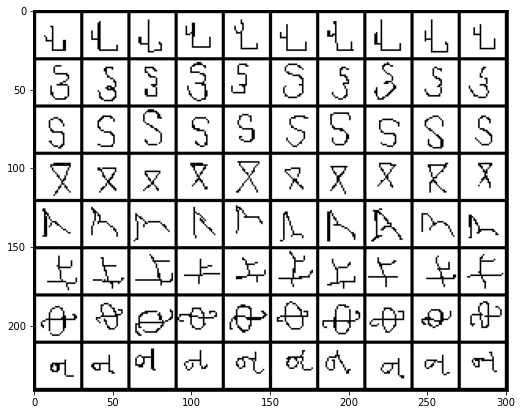

In [8]:
from matplotlib import pyplot as plt

def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  # need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  # make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

sample_example = dataloader.extract_sample(8, 5, 5, train_x, train_y)
display_sample(sample_example['images'])

In [9]:
encoder = Encoder()
model = Protonet(encoder)

In [10]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

n_way = 60
n_support = 5
n_query = 5

max_epoch = 5
epoch_size = 2000

Train.train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size, dataloader)


Epoch 1 -- Loss: 0.1144 Acc: 0.9643



Epoch 2 -- Loss: 0.0473 Acc: 0.9830



Epoch 3 -- Loss: 0.0341 Acc: 0.9874



Epoch 4 -- Loss: 0.0300 Acc: 0.9885



Epoch 5 -- Loss: 0.0266 Acc: 0.9897


In [11]:
torch.save(model.state_dict(), "/kaggle/working/prototype_model.h5")

In [12]:
saved_model = Protonet(encoder)
model.load_state_dict(torch.load("/kaggle/working/prototype_model.h5"))
model.eval()

Protonet(
  (Encoder): Encoder(
    (encode): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3):

In [13]:
n_way = 5
n_support = 5
n_query = 5

test_episode = 1000

Train.test(model, test_x, test_y, n_way, n_support, n_query, test_episode, dataloader)


Test results -- Loss: 0.0235 Acc: 0.9960


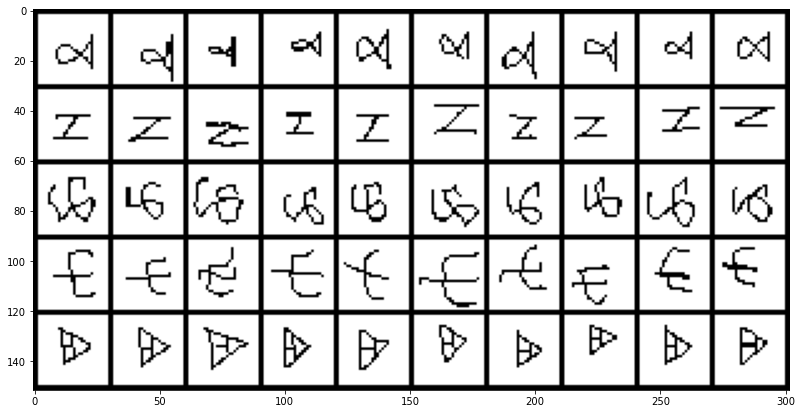

In [14]:
my_sample = dataloader.extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [15]:
my_loss, my_output = model.forward_loss(my_sample)
my_output

{'loss': 4.978179731551791e-06,
 'acc': 1.0,
 'y_predicted': tensor([[0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2],
         [3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4]], device='cuda:0')}